In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import fmm3dpy as fmm


from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches

from HODLR import *

from IPython.display import clear_output

%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['text.latex.preamble'] = r'\renewcommand{\vec}{\mathbf}'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
N = 14
n = 2**N

x = np.linspace(-4,4,n)
y = np.sin(2*np.pi*x) + 5e-2*np.random.randn(n)
z = np.cos(2*np.pi*x) + 5e-2*np.random.randn(n)

sources = np.zeros((3,n))
sources[0] = x
sources[1] = y
sources[2] = z
eps = 1e-4

In [4]:
def A_matvec(x):

    if x.ndim>1 and x.shape[1]>1:
        return fmm.lfmm3d(eps=eps,sources=sources,charges=x.T,pg=1,nd=x.shape[1]).pot.T
    else:
        return fmm.lfmm3d(eps=eps,sources=sources,charges=x,pg=1,nd=1).pot
    

In [5]:
A = 1/np.sqrt((x-x[:,None])**2 + (y-y[:,None])**2+(z-z[:,None])**2)
np.fill_diagonal(A,0)

/tmp/ipykernel_1652443/3266790205.py:1: RuntimeWarning: divide by zero encountered in divide
  A = 1/np.sqrt((x-x[:,None])**2 + (y-y[:,None])**2+(z-z[:,None])**2)


In [6]:
X = np.random.randn(n,2)
np.linalg.norm(A@X - A_matvec(X))/np.linalg.norm(A)

2.7960771437509257e-08

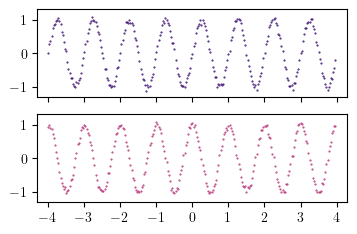

In [7]:
fig,axs = plt.subplots(2,1,figsize=(4,2.5),sharex='col')

c0 = plt.cm.magma(.2)
c1 = plt.cm.magma(.5)
axs[0].plot(x[::2**(N-8)],y[::2**(N-8)],marker='.',ms=1,linestyle='None',color=c0)
axs[1].plot(x[::2**(N-8)],z[::2**(N-8)],marker='.',ms=1,linestyle='None',color=c1)

axs[0].set_yticks([-1,0,1])
axs[1].set_yticks([-1,0,1])
axs[0].set_ylim(-1.3,1.3)
axs[1].set_ylim(-1.3,1.3)

axs[1].set_xlim(-4.3,4.3)
axs[1].set_xticks(range(-4,5,1))

plt.savefig('imgs/distances_setup.pdf')

/tmp/ipykernel_1652443/2104634653.py:3: RuntimeWarning: divide by zero encountered in log
  ax.imshow(np.log(np.abs(A[::2**(N-8),::2**(N-8)])),cmap='magma',rasterized=True)


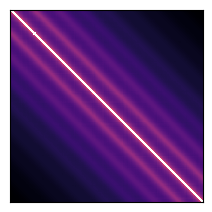

In [8]:
fig,ax = plt.subplots(1,1,figsize=(3,2.5),sharex='col')

ax.imshow(np.log(np.abs(A[::2**(N-8),::2**(N-8)])),cmap='magma',rasterized=True)
ax.set_xticks([])
ax.set_yticks([])

plt.savefig('imgs/distances_Aij.pdf')

In [9]:
n_repeat = 1

ks = [25,20,15,10,5,1]
βs = [.3,.5,.75]

names = ['GN1','GN2','RSVD1','RSVD2','GN1_nt','GN2_nt','RSVD1_nt','RSVD2_nt']

errs = {name:np.full((len(ks),len(βs),n_repeat),np.nan) for name in names}

n_trace_sample = 300
norm_A = estimate_norm(A.dot,A.dot,lambda X: np.zeros_like(X),lambda X: np.zeros_like(X),n,n_trace_sample)

for i,k in enumerate(ks):
    
    # A_opt = opt_HODLR(A,k)
    # err_opt[i] = np.linalg.norm(A-A_opt)

    for j,β in enumerate(βs):
        sr = int(k/β)
        sl = int(k/β**2)
        tr = int(1/β)
        tl = int(1/β)

        experiments = [{'name':'GN1','alg':GN_perf_peel,'params':[sr,1,sl,1,True]},\
                       {'name':'RSVD1','alg':RSVD_perf_peel,'params':[sr,1,1,True]}\
                      ]
        
        for l in range(n_repeat):
            print(f'{i},{j},{l}: k={k} sr={sr} sl={sl}')
            clear_output(wait=True)

            for experiment in experiments:
                
                name = experiment['name']
                alg = experiment['alg']
                params = experiment['params']
                
                np.random.seed(l)
                A_tilde = alg(A_matvec,A_matvec,n,k,*params)
                
                errs[name][i,j,l] = implicit_err(A.dot,A_tilde.matvec,n,min(n,2**15)) 

In [10]:
np.save('kernel_errs.npy',errs,allow_pickle=True)

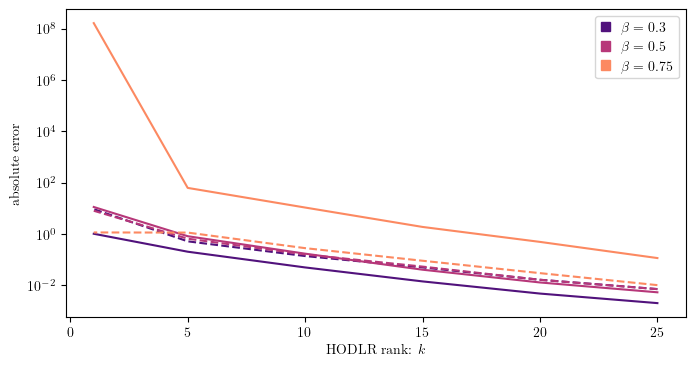

In [11]:
fig,axs = plt.subplots(1,1,figsize=(8,4),sharex=True,sharey=True)
fig.subplots_adjust(wspace=.1)

handles = []

for j,β in enumerate(βs):
    c = plt.cm.magma((j+1)/(len(βs)+1))
    axs.plot(ks,np.mean(errs['GN1'][:,j],axis=1)/norm_A,color=c)
    axs.plot(ks,np.mean(errs['RSVD1'][:,j],axis=1)/norm_A,color=c,ls='--')
    handles.append(mpatches.Circle((0,0),.5,color=c,label=rf'$\beta={β}$'))

axs.legend(handles=handles,loc='upper right',handlelength=0.7)

axs.set_xlabel(r'HODLR rank: $k$')


axs.set_ylabel('absolute error')

axs.set_yscale('log')

plt.savefig('imgs/distances_oversample_rank.pdf')